In [53]:
## For debbugging
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [56]:
## for debugging:
# %aimport mlp.keyword
# %aimport mlp.tools
%aimport mlp.kex
%aimport app.test_app
%aimport mlp.tree
%aimport mlp.plot
%autoreload 1
from mlp.kex import *
from mlp.tree import node_adj_mat, tag_network, tag_df_network
from mlp.plot import hv_net
from bokeh.palettes import Viridis10, Category10_6
import networkx as nx

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [58]:
%gui qt
import PyQt5.QtWidgets as qw
from app.test_app import MyWindow
from PyQt5 import QtCore



In [59]:
import dask.dataframe as dd
import dask
import string
from fuzzywuzzy import process as zz


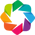

In [60]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=600 height=400]

# Manufacturing Maintenance Case Study

### Import Data

In [190]:
# cols = [1,2,3,4,5,6,7,8,11,12]
cols = [2,3,4,5,6,8,9,10,13,14, 31, 32, 33, 34, 35, 36]
data_dir = module_path/'data'/'arm_data'
# df = pd.read_csv('line_data.csv', skiprows=4, usecols=cols, 
#                  parse_dates=[0], thousands=',', nrows=1770)
df = pd.read_csv(data_dir/'line_data_timed.csv', usecols=cols, 
                 parse_dates={'date':[4]}, thousands=',', infer_datetime_format=True, index_col='date')
names = df.columns.str.lower().str.replace('[^\w\s]','').str.replace(' ', '_').str.replace(u'\u00B2', '2').tolist()
names[8] = 'scrap_comments'
df.columns = names
df = df.drop(df[(df.commodity == 'D. Day')|(df.commodity == 'D. DAY')].index)
# for col in ['shift','commodity','pattern','scrap_reason']:
#     df.loc[:,col] = df[col].astype('category')
for col in ['good_cartons', 'scrap_cartons', 
            'scrap_ft2', 'produced_ft2', 
            'budgeted_ft2', 'budgeted_scrap_ft2', 
            'budgeted_cartons', 'budgeted_scrap_cartons']:
    df.loc[:,col] = pd.to_numeric(df[col].str.replace(',',''), errors='coerce')
df = df.dropna(subset=['good_cartons', 'scrap_cartons', 'sqft'])

df.index = pd.to_datetime(df.index,unit='s')
df = df.sort_index()
# Pattern and reason have many categories. Set a "scrap-explained" threshold of, say, 90%
pattern_scrap = df.groupby('pattern').scrap_cartons.sum().sort_values(ascending=False)
pattern_ratio = pattern_scrap.cumsum()/pattern_scrap.sum()
df.loc[:,'pattern'] = df.pattern.replace(pattern_ratio[pattern_ratio>=.9].index.tolist(), np.nan)

# reas_scrap = df.groupby('scrap_reason').scrap_cartons.sum().sort_values(ascending=False)
# scrap_ratio = reas_scrap.cumsum()/reas_scrap.sum()
# df.loc[:,'scrap_reason'] = df.scrap_reason.replace(scrap_ratio[scrap_ratio>=.9].index.tolist(), np.nan)


# df['scrap_fraction'] = df.scrap_cartons/(df.good_cartons+df.scrap_cartons)

# # assuming produced/budgeted is only "good"
# df['scrap_fraction'] = df.scrap_ft2/(df.produced_ft2+df.scrap_ft2)
# df['expected_scrap_frac'] = df.budgeted_scrap_ft2/(df.budgeted_ft2+df.budgeted_scrap_ft2)

# assuming produced/budgeted is only "good", using cartons
df['scrap_fraction'] = df.scrap_cartons/(df.good_cartons+df.scrap_cartons)
df['expected_scrap_frac'] = df.scrap_cartons/(df.budgeted_scrap_cartons+df.budgeted_cartons)

# # assuming produced/budgeted is all
# df['scrap_fraction'] = df.scrap_ft2/(df.produced_ft2)
# df['expected_scrap_frac'] = df.budgeted_scrap_ft2/(df.budgeted_ft2)

df['scrap_rate'] = df.scrap_cartons/df.hrs
df = df.dropna(subset=['scrap_cartons', 'good_cartons', 'scrap_rate', 'scrap_fraction'])

m = {"Imperial": ['Imperial 1/8', 'Civic Square'],
     "Rafia": ['Raffia', 'Raffia Storm', 'Raffia Stream'],
     "Striations": ["Striations"],
     "Migrations": ["Migrations"],
     "TEST": ["TEST"]}
m2 = {v: k for k,vv in m.items() for v in vv}

df.loc[:,'commodity'] = df.commodity.map(m2)#.astype("category")

print(df.shape)
df.head(10)

(1666, 18)


shift commodity pattern   hrs      sqft  good_cartons  \
date                                                                          
2017-01-04 06:00:00  7112.0  Imperial   51860  1.00   11970.0         266.0   
2017-01-04 07:00:00  7112.0  Imperial   51903  7.00  125010.0        2778.0   
2017-01-04 14:00:00  7113.0  Imperial   51811  0.75    2205.0          49.0   
2017-01-04 14:45:00  7113.0  Imperial   51860  3.25   76680.0        1704.0   
2017-01-04 18:00:00  7113.0  Imperial   51861  4.00   93960.0        2088.0   
2017-01-05 06:00:00  7111.0  Imperial   51811  8.00  204480.0        4544.0   
2017-01-05 14:00:00  7112.0  Imperial   51915  0.67    7065.0         157.0   
2017-01-05 14:40:12  7112.0  Imperial   54004  3.08   71460.0        1588.0   
2017-01-05 17:45:00  7112.0  Imperial   51830  3.58   90045.0        2001.0   
2017-01-05 21:19:48  7112.0  Imperial   51811  0.67   19395.0         431.0   

                     scrap_cartons     scrap_reason  \
date                                                  
2017-01-04 06:00:00          152.0    Foreign Color   
2017-01-04 07:00:00          546.0         Start Up   
2017-01-04 14:00:00          384.0    Foreign Color   
2017-01-04 14:45:00          270.0        Press Jam   
2017-01-04 18:00:00          220.0        Press Jam   
2017-01-05 06:00:00          346.0        Allowance   
2017-01-05 14:00:00          141.0     Patt. Change   
2017-01-05 14:40:12          268.0  Blanket Quality   
2017-01-05 17:45:00          158.0        Allowance   
2017-01-05 21:19:48           25.0        Allowance   

                                                        scrap_comments  \
date                                                                     
2017-01-04 06:00:00               Foregin color in start up of pattern   
2017-01-04 07:00:00  Start up after holiday shut down, Jam at 1'st ...   
2017-01-04 14:00:00                     contaminated 1st and 3rd blend   
2017-01-04 14:45:00          foregin color, press jam and East counter   
2017-01-04 18:00:00                 2 press jams, tightened D conveyor   
2017-01-05 06:00:00                                                NaN   
2017-01-05 14:00:00                  Moving from a tan to gray pattern   
2017-01-05 14:40:12      Large waves/rolls in the west tile during run   
2017-01-05 17:45:00                                                NaN   
2017-01-05 21:19:48                                                NaN   

                     budgeted_cartons  budgeted_ft2  produced_ft2  \
date                                                                
2017-01-04 06:00:00             490.0       22042.0       11970.0   
2017-01-04 07:00:00            3429.0      154294.0      125010.0   
2017-01-04 14:00:00             367.0       16532.0        2205.0   
2017-01-04 14:45:00            1592.0       71637.0       76680.0   
2017-01-04 18:00:00            1959.0       88168.0       93960.0   
2017-01-05 06:00:00            3919.0      176336.0      204480.0   
2017-01-05 14:00:00             328.0       14768.0        7065.0   
2017-01-05 14:40:12            1509.0       67889.0       71460.0   
2017-01-05 17:45:00            1754.0       78910.0       90045.0   
2017-01-05 21:19:48             328.0       14768.0       19395.0   

                     budgeted_scrap_cartons  budgeted_scrap_ft2  scrap_ft2  \
date                                                                         
2017-01-04 06:00:00                    24.0              1693.0     6840.0   
2017-01-04 07:00:00                   250.0             13462.0    24570.0   
2017-01-04 14:00:00                     4.0              1754.0    17280.0   
2017-01-04 14:45:00                   153.0              7995.0    12150.0   
2017-01-04 18:00:00                   188.0              9347.0     9900.0   
2017-01-05 06:00:00                   409.0             19805.0    15570.0   
2017-01-05 14:00:00                    14.0              1207.0     63

In [191]:
# data_dir = module_path/'data'/'arm_data'

# df = dd.read_csv(data_dir/'line_data_timed.csv', dtype={'Shift': 'object'})


gs_nlp_select = NLPSelect(columns = ['scrap_reason', 'scrap_comments', 'pattern'])

raw_text = gs_nlp_select.transform(df)

### Build Vocabulary

In [192]:
tex = TokenExtractor()
toks = tex.fit_transform(raw_text)
# print(tex.vocab_[:10])

In [193]:
vocab_fname = data_dir/'vocab.csv'
# vocab_fname = data_dir/'mine_vocab_app.csv'
 
vocab = tex.annotation_assistant(filename=vocab_fname)

attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


In [65]:
if __name__ == '__main__':

    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = app = qw.QApplication(sys.argv)

    window = MyWindow(vocab_filename=vocab_fname)
#     window = MyWindow()
    window.show()

    app.exec_()

In [34]:
vocab = tex.annotation_assistant(init=vocab_fname)

intialized successfully!


### Extract Keywords

In [208]:
tag_df = tags_to_df(tag_extractor(tex, raw_text, toks, vocab), idx_col=df.index)

HBox(children=(IntProgress(value=0, description='Category Loop', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=66), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=575), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P token loop', max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S token loop', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='U token loop', max=4), HTML(value='')))

In [209]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  141
total tags:  42


NE  alias  notes  score
NE                         
I    1     26      0    110
P    1     12      0     26
S    1      1      0      1
U    1      3      0      4

Tag completeness: 0.84 +/- 0.21
Tag empty: 29, or 1.74%


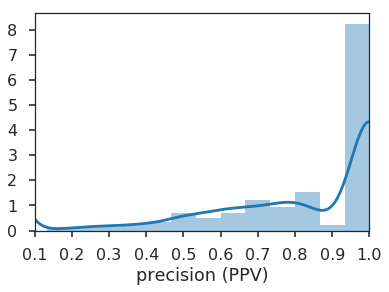

In [210]:
# tag-completeness of work-orders?
wo_tot = len(df)
tag_comp = 1-(tag_df['NA'].sum(axis=1)/tag_df.sum(axis=1))
              
print(f'Tag completeness: {tag_comp.mean():.2f} +/- {tag_comp.std():.2f}')
with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    sns.distplot(tag_comp.dropna(), bins=15, kde_kws={'cut':0})
    plt.xlim(0.1, 1.0)
    plt.xlabel('precision (PPV)')
    # sns.kdeplot()

# tag-empty? 
tag_empt = ((tag_df['I'].sum(axis=1)==0)&(tag_df['P'].sum(axis=1)==0)&(tag_df['S'].sum(axis=1)==0)).sum()
print(f'Tag empty: {tag_empt}, or {tag_empt/wo_tot:.2%}')

## Measuring Machine Performance

In [197]:
colors = {
            'P':'#C0504D',
            'S':'#7ABC32',
            'I':'#4F81BD',
            'U':'#ffc000',
            'NA':'gray',
            'X':'black'
        }

{'Imperial': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'Striations': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), 'Migrations': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), 'Rafia': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), 'TEST': (1.0, 0.4980392156862745, 0.0)}


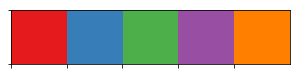

In [198]:
comm_names = df.commodity.unique().tolist()

# List of RGB triplets
rgb_values = sns.color_palette("Set1", n_colors=len(comm_names))
sns.palplot(rgb_values)

# Map label to RGB
color_map = dict(zip(comm_names, rgb_values))
print(color_map)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


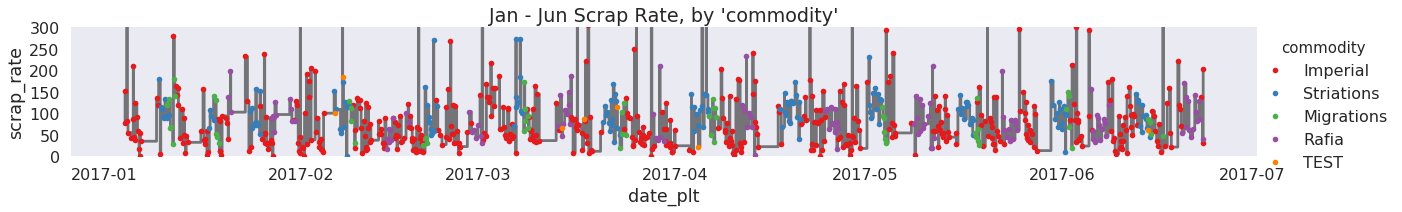

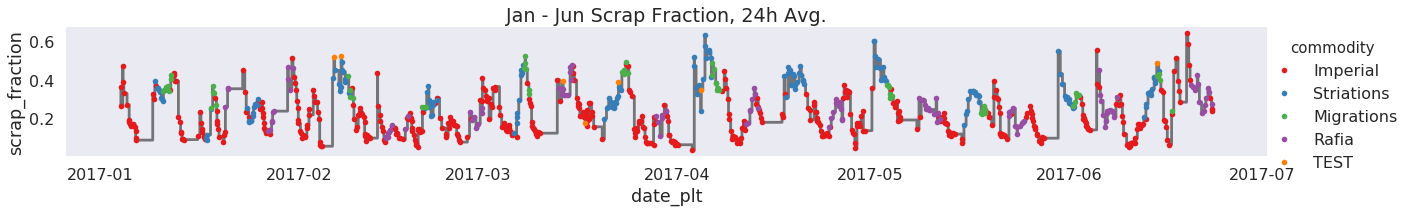

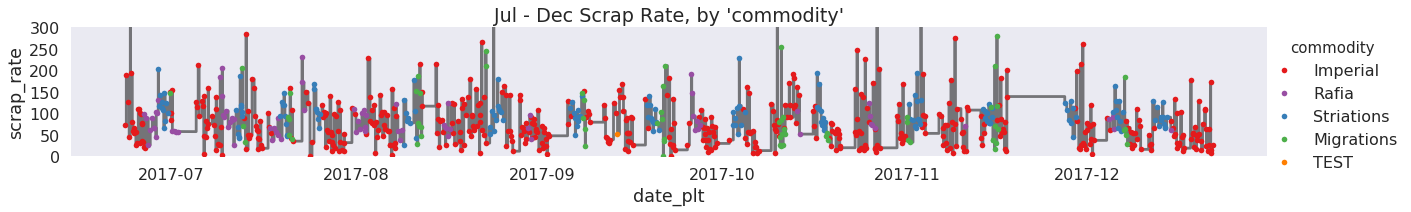

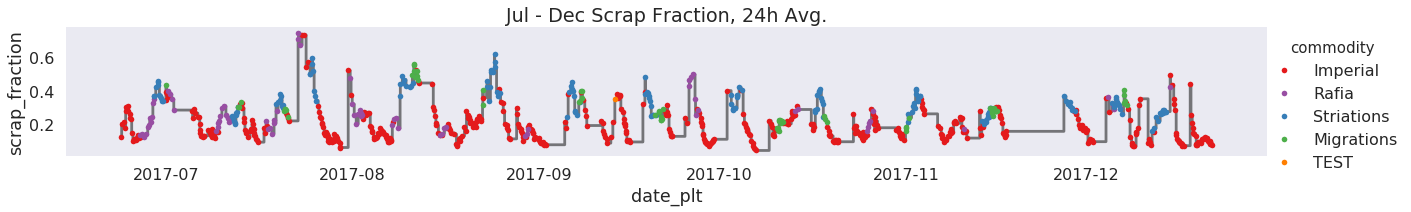

In [199]:
# f, ax = plt.subplots(nrows=4)

with sns.axes_style('dark') as style,\
sns.plotting_context('poster') as context:
    dfr = df.iloc[:833,:].copy()
    dfr['date_plt'] = dfr.index
    fg = sns.FacetGrid(data=dfr, hue='commodity', aspect=6., palette=color_map, size=3)
    fg.map(plt.plot, 'date_plt', 'scrap_rate', marker='.', ls='').add_legend()
    plt.gca().step(dfr.index, dfr.scrap_rate, alpha=.5, zorder=0, ls='-', c='k', where='post')
    plt.gca().set_ylim(0,300)
    plt.gca().set_title("Jan - Jun Scrap Rate, by \'commodity\'")
    
with sns.axes_style('dark') as style,\
sns.plotting_context('poster') as context:
    dfr = df.iloc[:833,:].rolling('24H').mean()
    dfr['date_plt'] = dfr.index
    fg = sns.FacetGrid(data=dfr, hue='commodity', aspect=6., palette=color_map, size=3)
    fg.map(plt.plot, 'date_plt', 'scrap_fraction', marker='.', ls='').add_legend()
    plt.gca().step(dfr.index, dfr.scrap_fraction, alpha=.5, zorder=0, c='k', where='post')
    plt.gca().set_title("Jan - Jun Scrap Fraction, 24h Avg.")
    
with sns.axes_style('dark') as style,\
sns.plotting_context('poster') as context:
    dfr = df.iloc[833:,:].copy()
    dfr['date_plt'] = dfr.index
    fg = sns.FacetGrid(data=dfr, hue='commodity', aspect=6., palette=color_map, size=3)
    fg.map(plt.plot, 'date_plt', 'scrap_rate', marker='.', ls='').add_legend()
    plt.gca().step(dfr.index, dfr.scrap_rate, alpha=.5, zorder=0, ls='-', c='k', where='post')
    plt.gca().set_ylim(0,300)
    plt.gca().set_title("Jul - Dec Scrap Rate, by \'commodity\'")
    
with sns.axes_style('dark') as style,\
sns.plotting_context('poster') as context:
    dfr = df.iloc[833:,:].rolling('24H').mean()
    dfr['date_plt'] = dfr.index
    fg = sns.FacetGrid(data=dfr, hue='commodity', aspect=6., palette=color_map, size=3)
    fg.map(plt.plot, 'date_plt', 'scrap_fraction', marker='.', ls='').add_legend()
    plt.gca().step(dfr.index, dfr.scrap_fraction, alpha=.5, zorder=0, c='k', where='post')
    plt.gca().set_title("Jul - Dec Scrap Fraction, 24h Avg.")
#     plt.step()

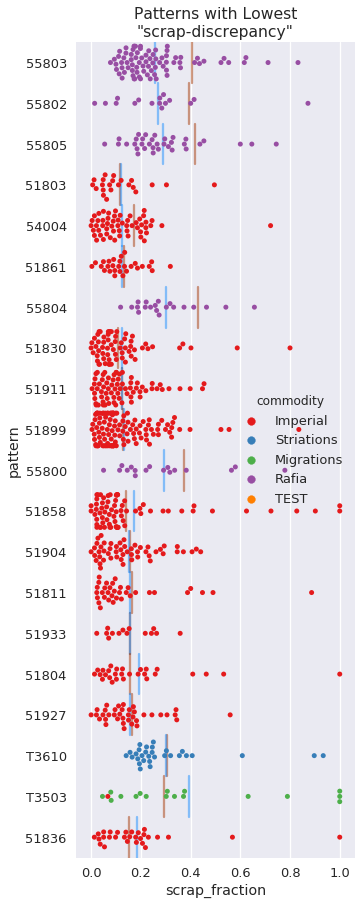

In [200]:
# samp = ['broken', 'motor' ]
# order = df.groupby('pattern')['scrap_fraction'].mean().sort_values(ascending=False).index[:20]
order = (grp['scrap_fraction'].mean() -\
         grp['expected_scrap_frac'].mean()).sort_values(ascending=True).index[:20]
grp = df.groupby('pattern')
with sns.axes_style('darkgrid') as style,\
sns.plotting_context('talk') as context:
    plt.figure(figsize=(5, 15))

    sns.swarmplot(data=df, orient='h', y='pattern', x='scrap_fraction', 
                hue='commodity', order=order,palette=color_map)
    for n, patt in enumerate(order):
        plt.axvline(grp.get_group(patt).expected_scrap_frac.mean(), 
                    (20-n)/20, (19-n)/20, color='xkcd:rust', alpha=.5)
        plt.axvline(grp.get_group(patt).scrap_fraction.mean(), 
            (20-n)/20, (19-n)/20, color='dodgerblue', alpha=.5)
    plt.title('Patterns with Lowest\n\"scrap-discrepancy\"')


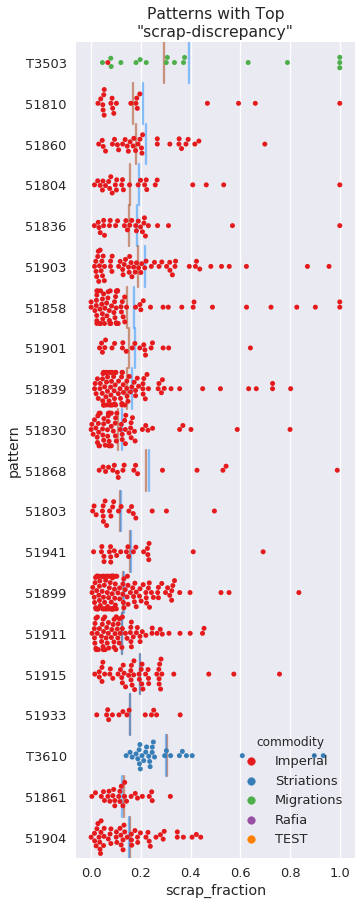

In [201]:
# samp = ['broken', 'motor' ]
# order = df.groupby('pattern')['scrap_fraction'].mean().sort_values(ascending=False).index[:20]
order = (grp['scrap_fraction'].mean() -\
         grp['expected_scrap_frac'].mean()).sort_values(ascending=False).index[:20]
grp = df.groupby('pattern')
with sns.axes_style('darkgrid') as style,\
sns.plotting_context('talk') as context:
    plt.figure(figsize=(5, 15))

    sns.swarmplot(data=df, orient='h', y='pattern', x='scrap_fraction', 
                hue='commodity', order=order,palette=color_map)
    for n, patt in enumerate(order):
        plt.axvline(grp.get_group(patt).expected_scrap_frac.mean(), 
                    (20-n)/20, (19-n)/20, color='xkcd:rust', alpha=.5)
        plt.axvline(grp.get_group(patt).scrap_fraction.mean(), 
            (20-n)/20, (19-n)/20, color='dodgerblue', alpha=.5)
    plt.title('Patterns with Top\n\"scrap-discrepancy\"')


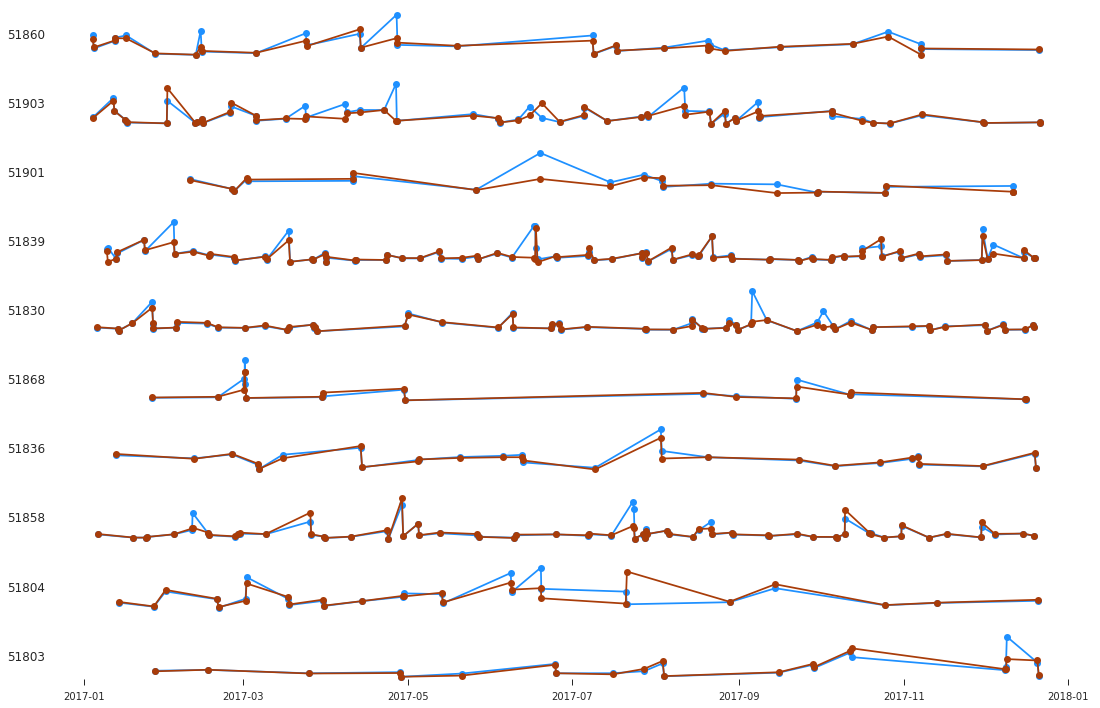

In [222]:
## order = df.pattern.value_counts().index[:10]
# order = df.groupby('pattern')['scrap_fraction'].mean().sort_values(ascending=False).index[:10]
grp = df.dropna(subset=['expected_scrap_frac', 'scrap_fraction']).groupby('pattern')

n_top = 10
order = (grp['scrap_fraction'].mean() -\
         grp['expected_scrap_frac'].mean()).sort_values(ascending=False).index[:n_top]

with sns.axes_style('ticks') as style,\
sns.plotting_context('notebook') as context:
    f, ax = plt.subplots(nrows = n_top, sharex=True, figsize=(15, n_top))
    for n, patt in enumerate(order):

#         fig.add_subplot(411)
        df_patt = grp.get_group(patt)
        ax[n].plot(df_patt.index, n+df_patt.scrap_fraction,
                   marker='o', ls='-', color='dodgerblue', clip_on=False)
        ax[n].plot(df_patt.index, n+df_patt.expected_scrap_frac,
                   marker='o', ls='-', color='xkcd:rust', clip_on=False)
        ax[n].text(0., 0.5,patt,
#             df_patt.index[0], df_patt.iloc[0].scrap_fraction, patt,
                  horizontalalignment='right', verticalalignment='center', 
                   clip_on=False, zorder=20, transform=ax[n].transAxes)
#         plt.text()
        plt.setp(ax[n].get_xticklabels(), visible=False)
        plt.setp(ax[n].get_yticklabels(), visible=False)
        plt.setp(ax[n].get_xticklines(), visible=False)
        plt.setp(ax[n].get_yticklines(), visible=False)
        plt.setp(ax[n].spines.values(), visible=False)
    plt.setp(ax[-1].get_xticklabels(), visible=True)
    plt.setp(ax[-1].get_xticklines(), visible=True)
    ax[-1].xaxis.tick_bottom() # but onlyt the lower x ticks not x ticks at the top

    plt.tight_layout()
# dfr = df.copy()#.resample('3W').mean()
# dfr['date'] = dfr.index
# with sns.axes_style('dark') as style,\
# sns.plotting_context('poster') as context:
#     # sns.countplot(data=df, y='pattern', x='tbf', hue='mach_type', orient='h', order=order[:20], notch=False)
#     fg = sns.FacetGrid(data=dfr[dfr.pattern.isin(order)], aspect=8., row='pattern', row_order=order)
#     fg.map(plt.plot, 'date', 'scrap_fraction', 
#            marker='o', ls=':', color='dodgerblue')#.add_legend()
#     fg.map(plt.plot, 'date', 'expected_scrap_frac', 
#            marker='o', ls=':', color='xkcd:rust')#.add_legend()

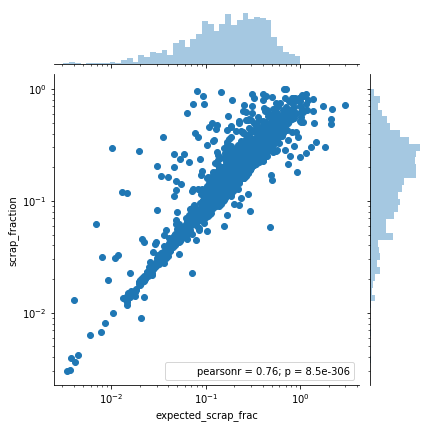

In [203]:
mybins=np.logspace(-3,0,50)
g = sns.jointplot('expected_scrap_frac', 'scrap_fraction', data=df, kind='scatter', marginal_kws={'bins':mybins})

ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

In [122]:
#bucket them together by continuous commodity runs

df_bin = df.copy()
# df_bin.

df_bin['key'] = (df['commodity'] != df['commodity'].shift(1)).astype(int).cumsum()
df_bin['date'] = df.index
df_bin = df_bin.groupby(['key', 'commodity']).agg({'scrap_cartons':['sum'], 
                                                   'scrap_rate':['mean'],
                                                   'scrap_fraction': ['mean'],
                                                   'hrs': ['sum'],
                                                   'date': ['min']
                                                  }).reset_index()

df_bin.columns = df_bin.columns.get_level_values(0)
df_bin.loc[:,'commodity'] = df_bin.commodity.astype(str)
# df_bin.replace(to_replace={'commodity':{'Imperial 1/8':'Imperial', 'Civic Square':'Imperial'}}, inplace=True)
# df_bin.set_index('date')
df_bin['log_rate'] = np.log(df_bin.scrap_rate+.01)
df_bin['switch'] = df_bin.commodity.shift(-1).astype(str) +'-->'+ df_bin.commodity.astype(str)
df_bin['op_time']  = df_bin.hrs.cumsum()

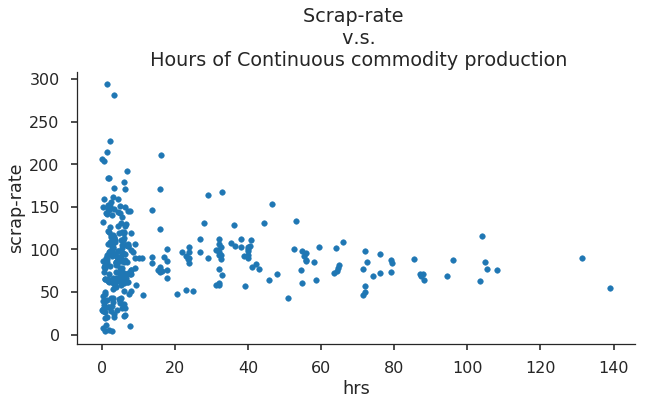

In [125]:
with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(10,5))
    plt.scatter(df_bin[df_bin.scrap_rate<1000].hrs, 
                df_bin[df_bin.scrap_rate<1000].scrap_rate, 
                marker='.', clip_on=False)
    plt.xlabel('hrs')
    plt.ylabel('scrap-rate')
    plt.title('Scrap-rate \n v.s.\n Hours of Continuous commodity production')
    sns.despine()

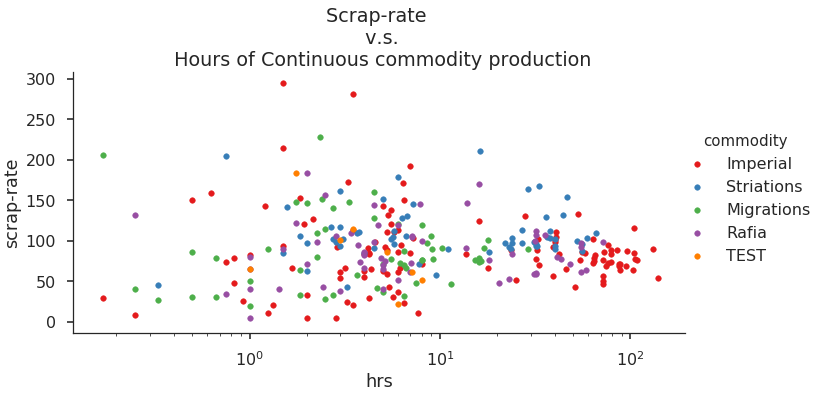

In [129]:
with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    fg = sns.FacetGrid(data=df_bin, 
                       hue='commodity', aspect=2., palette=color_map, size=5)
    fg.map(plt.scatter, 'hrs', 'scrap_rate', marker='.').add_legend()
    sns.factorplot
#     plt.figure(figsize=(10,5))
#     plt.scatter(df_bin[df_bin.scrap_rate<1000].hrs, 
#                 df_bin[df_bin.scrap_rate<1000].scrap_rate, 
#                 marker='.', clip_on=False)
    plt.xlabel('hrs')
    plt.ylabel('scrap-rate')
    plt.title('Scrap-rate \n v.s.\n Hours of Continuous commodity production')
    sns.despine()
    plt.xscale('log')
#     plt.yscale('log')

### Failure Inter-arrival Times, by Machine


Ordered by total occurences (i.e. "distribution certainty")

- Time between occurences of `broken` tag.
- low $\rightarrow$ bad
- e.g. `H34`, `I19`, and `H14` all seem rather low

What could be the central problems with these machines?

### Top Tag occurences, by Machine

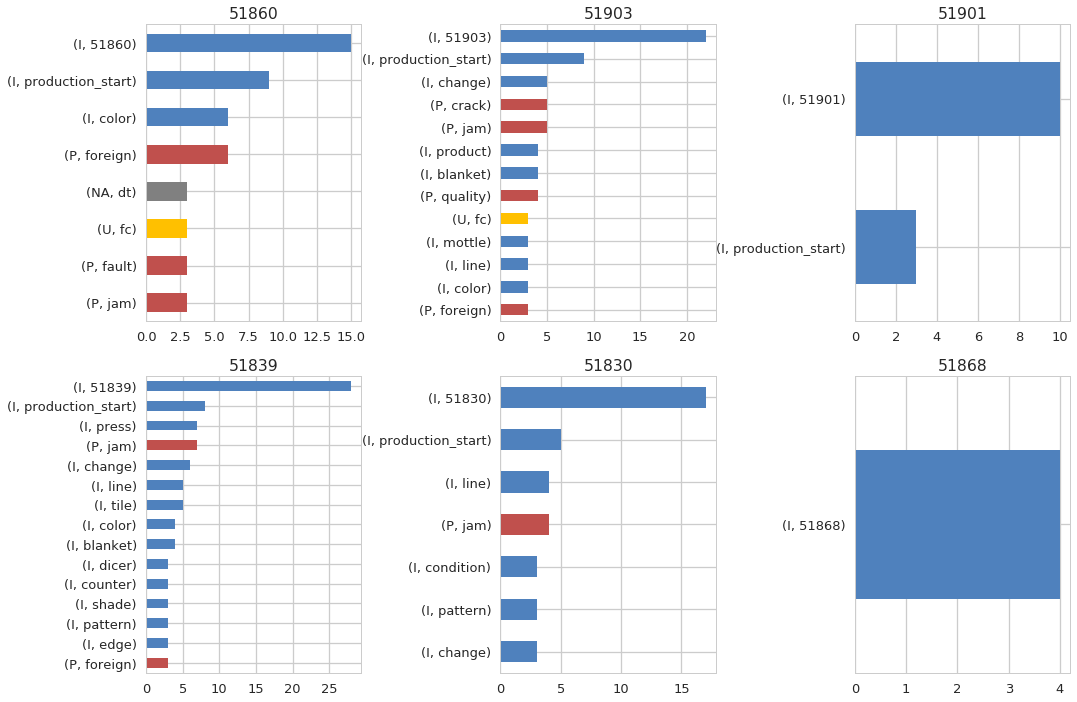

In [236]:
# top3 = sample_tag.MACH.isin(['H34', 'I19', 'H14'])
# sample_tag[top3, sample_tag.loc[top3,:].sum()>3].groupby('MACH').sum().plot(kind='bar')
# tag_df[sample_tag.MACH=='H34'].sum()

def pattern_tags(name, n_reps, discrep=False):
    isguy = df['pattern']==name
    if discrep:
        isguy = isguy & (df.scrap_fraction - df.expected_scrap_frac >0)
#     tag_df.set_index(df.index)
    return tag_df.loc[isguy,(tag_df.loc[isguy,:].sum()>n_reps).values]


with sns.axes_style('whitegrid') as style,\
sns.plotting_context('talk') as context:
    f, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

    for n, mach in enumerate(['51860', '51903','51901', '51839', '51830', '51868']):
        mach_df = pattern_tags(mach,  2, discrep=True).sum().sort_values()
        try:
            mach_df.plot(kind='barh', color=[colors[i] for i in mach_df.index.get_level_values(0)], 
                         ax=ax.flatten()[n])
        except TypeError:
            next
        ax.flatten()[n].set_title(mach)
    plt.tight_layout()

- `H34` issues with `motor`, `unit`, `brush`
- `I19` `alarm`s and/or `sensors`, potentially coolant-related
- `H14` wide array of issues, including `operator` (!?)

Index(['change', 'pattern'], dtype='object')


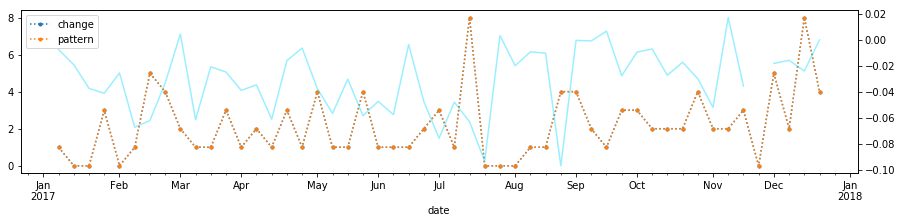

In [237]:
# wo_num = 0
# sample_tag = tag_df.loc[:,tag_df.loc[wo_num].astype(bool)]
is_change = (tag_df.I['pattern']>0) & (tag_df.I['change']>0)
samp = ['pattern', 'change']
sample_tag = tag_df.loc[is_change,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

# sample_tag = tag_df[['chain', 'bar', 'accumulator']]
# idx_col = df.index
# sample_tag = sample_tag.set_index(idx_col[is_change])
# .rolling(1000).sum()
# plt.figure()
sample_tag.resample('1W').sum().plot(figsize=(15,3), marker='.', ls=':')
ax2 = plt.twinx()
# df['scrap_fraction'].resample('1W').mean().plot(ax = ax2, color='xkcd:algae', alpha=.4)
# df['expected_scrap_frac'].resample('1W').mean().plot(ax = ax2, color='xkcd:slate', alpha=.4)
(df['scrap_fraction'] - df['expected_scrap_frac']).resample('1W').mean().plot(ax = ax2, color='xkcd:neon blue', alpha=.4)
# df.resample()
print(sample_tag.columns)

#### Machines Pt. II

In [240]:
%%output size=200
%%opts Text (text_align='r')
%%opts Graph (edge_line_width=4 node_line_color='white', node_size=1)
%%opts EdgePaths [color_index='weight'] (line_width=1, cmap='viridis', color='dodgerblue', alpha=.2)
%%opts Overlay [width=300 legend_position='top_right'] Layout [tabs=True]
%%opts Nodes (size='size' line_color='white')
# padding = dict(x=(-0.05, 1.05), y=(-0.05, 1.05))


kws = {'layout':nx.drawing.spring_layout, 
#        'layout_kws':{'prog':'neato'},
       'padding':dict(x=(-0.05, 1.05), y=(-0.05, 1.05))
      }
mach_list = ['51860', '51903','51901', '51839', '51830', '51868']
layout = hv.Layout([hv_net(pattern_tags(mach,  2, discrep=False), name=mach,**kws) for mach in mach_list])
layout

:Layout
   .A_51860.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51860.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51860.P   :Nodes   [x,y,index]   (count,size,NE)
      .A_51860.NA  :Nodes   [x,y,index]   (count,size,NE)
      .A_51860.U   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
      .Text.XV     :Text   [x,y]
      .Text.XVI    :Text   [x,y]
      .Text.XVII   :Text   [x,y]
      .Text.XVIII  :Text   [x,y]
   .A_51903.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51903.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51903.P   :Nodes   [x,y,index]   (count,size,NE)
      .A_51903.U   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
      .Text.XV     :Text   [x,y]
      .Text.XVI    :Text   [x,y]
      .Text.XVII   :Text   [x,y]
      .Text.XVIII  :Text   [x,y]
      .Text.XIX    :Text   [x,y]
      .Text.XX     :Text   [x,y]
      .Text.XXI    :Text   [x,y]
      .Text.XXII   :Text   [x,y]
      .Text.XXIII  :Text   [x,y]
      .Text.XXIV   :Text   [x,y]
   .A_51901.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51901.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51901.P   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
   .A_51839.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51839.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51839.P   :Nodes   [x,y,index]   (count,size,NE)
      .A_51839.NA  :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
      .Text.XV     :Text   [x,y]
      .Text.XVI    :Text   [x,y]
      .Text.XVII   :Text   [x,y]
      .Text.XVIII  :Text   [x,y]
      .Text.XIX    :Text   [x,y]
      .Text.XX     :Text   [x,y]
      .Text.XXI    :Text   [x,y]
      .Text.XXII   :Text   [x,y]
      .Text.XXIII  :Text   [x,y]
      .Text.XXIV   :Text   [x,y]
      .Text.XXV    :Text   [x,y]
      .Text.XXVI   :Text   [x,y]
      .Text.XXVII  :Text   [x,y]
      .Text.XXVIII :Text   [x,y]
      .Text.XXIX   :Text   [x,y]
      .Text.XXX    :Text   [x,y]
   .A_51830.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51830.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51830.P   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
    

In [242]:
%%output size=200
%%opts Text (text_align='r')
%%opts Graph (edge_line_width=4 node_line_color='white', node_size=1)
%%opts EdgePaths [color_index='weight'] (line_width=1, cmap='viridis', color='dodgerblue', alpha=.2)
%%opts Overlay [width=300 legend_position='top_right'] Layout [tabs=True]
%%opts Nodes (size='size' line_color='white')
# padding = dict(x=(-0.05, 1.05), y=(-0.05, 1.05))


kws = {'layout':nx.drawing.spring_layout, 
#        'layout_kws':{'prog':'neato'},
       'padding':dict(x=(-0.05, 1.05), y=(-0.05, 1.05))
      }
mach_list = ['51860', '51903','51901', '51839', '51830', '51868']
layout = hv.Layout([hv_net(pattern_tags(mach,  2, discrep=True), name=mach,**kws) for mach in mach_list])
layout

:Layout
   .A_51860.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51860.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51860.NA  :Nodes   [x,y,index]   (count,size,NE)
      .A_51860.P   :Nodes   [x,y,index]   (count,size,NE)
      .A_51860.U   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
   .A_51903.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51903.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51903.P   :Nodes   [x,y,index]   (count,size,NE)
      .A_51903.U   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
   .A_51901.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51901.I   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
   .A_51839.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51839.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51839.P   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
      .Text.XV     :Text   [x,y]
   .A_51830.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51830.I   :Nodes   [x,y,index]   (count,size,NE)
      .A_51830.P   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
   .A_51868.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .A_51868.I   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]

## Hierarchical Relationships

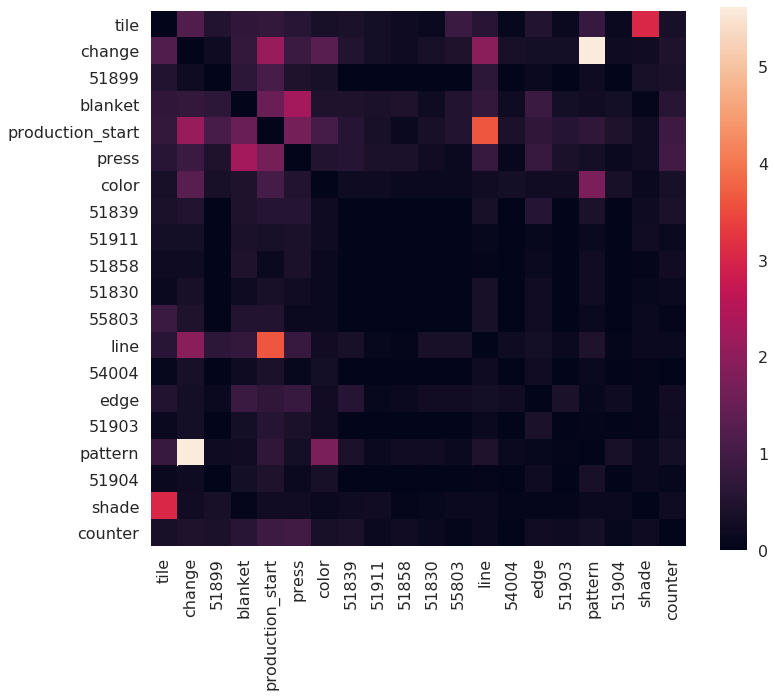

In [220]:
tag_similarity = mlp.tree.node_adj_mat(tag_df["I"])
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.heatmap(200*tag_similarity.iloc[:20,:20], square=True)


In [221]:
D = mlp.tree.heymann_taxonomy(tag_similarity, dynamic=False, verbose=True, tau=5e-4)


production_start


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 741.59it/s]


production_start
['t3609']


In [222]:
for n, d in enumerate(nx.weakly_connected_component_subgraphs(D)):
    print(nx.number_of_nodes(d))
    plt.figure(figsize=(15,15))
    nx.draw_networkx(d, pos=nx.drawing.nx_pydot.pydot_layout(d, prog='fdp'))

65


ModuleNotFoundError: No module named 'pydotplus'

In [227]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'production_start')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'production_start'), outfile)

In [229]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1400 - margin.right - margin.left,
    height = 900 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [230]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [231]:
f2(w=1500,h=1200)

In [33]:
thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
clean_text.compute()[:4]
# TfidfVectorizer()
# '(?u)\\b\\w\\w+\\b'

0     replace lubricant tank fill hose 
1         checked rotary head alignment
2       reweld shock sub to rotary head
3    centre tank not filling with water
dtype: object

In [34]:
from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)
voc2 = tex2.annotation_assistant(data_dir/'2g_mine_vocab_test.csv')

['lubricant service' 'oil leak' 'pm lubricant' ... 'station check'
 'check 24wk' 'fitter hydraulic']
New Vocab. file written to /home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/mine_data/2g_mine_vocab_test.csv


SystemExit: 0

/home/tbsexton/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [35]:
NE_dict = vocab.NE.fillna('U').to_dict()
NE_dict.update(vocab.fillna('U').reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)

# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

TypeError: object of type 'float' has no len()

In [147]:
NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}

NE_map['I I'] = 'I'
NE_map['S I'] = 'S I'
NE_map['P I'] = 'P I'

NE_map['I S'] = 'S I'
NE_map['I P'] = 'P I'

NE_map['S S'] = 'X'
NE_map['P P'] = 'X'
NE_map['S P'] = 'X'
NE_map['P S'] = 'X'
# NE_map['']
voc2['NE'] = voc2.NE.apply(lambda x: NE_map[x])
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
voc2['score'] = tex2.scores_
# voc2.NE

# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


I       P                  S U
0                 chain, feeder  broken             repair  
1  machine, cable, pendant, pin   short            replace  
2                          part  broken      order, repair  
3                   accumulator          ok, charge, check  
4    attachment, saw, hydraulic    leak            replace

In [140]:
tag_df['og'] = raw_text
tag_df

I                    P  \
0                                      chain, feeder               broken   
1                       machine, cable, pendant, pin                short   
2                                               part               broken   
3                                        accumulator                        
4                         attachment, saw, hydraulic                 leak   
5                                       unit, thread                        
6         saw, gear, shelf, attachment, person, unit                        
7                                        accumulator                        
8                             mill, spindle, station                        
9                                    line, hydraulic        rupture, leak   
10                                      chip, turret                 leak   
11                                    spindle, index                        
12                                                                          
13                     drill, unit, hydraulic, cross                 leak   
14                                       accumulator                        
15                                          conveyor                  jam   
16                                  motor, hydraulic                alarm   
17                                                                   leak   
18                                     screw, loader                        
19                                              part                 drop   
20                         chip, belt, box, conveyor           inoperable   
21                                              pump           inoperable   
22         bearing, shelf, steve, unit, drill, cross               broken   
23                  cable, sensor, unit, brush, prox                stuck   
24                             unit, attachment, saw                short   
25                                    chip, conveyor           inoperable   
26                         head, unit, belt, chamfer               broken   
27                                 head, screw, tool               broken   
28                             unit, attachment, saw                short   
29             station, spindle, drill, belt, pulley                        
...                                              ...                  ...   
3405                                     unit, brush                  jam   
3406                           clamp, screw, station                strip   
3407                             unit, brush, pulley       failure, stuck   
3408                                person, inverter                        
3409                                           motor                alarm   
3410              brake, station, unit, motor, brush       failure, fault   
3411                       unit, brake, brush, motor              failure   
3412                             holder, unit, brush                        
3413        operator, key, person, actuator, gripper  failure, inoperable   
3414                                   wire, breaker  short, trip, unable   
3415             bolt, station, motor, screw, pulley                loose   
3416                low_pressure, valve, accumulator                 leak   
3417                                            bowl               broken   
3418                       low_pressure, accumulator                issue   
3419            pressure, coolant, hydraulic, collet                 leak   
3420                                   counter, part                        
3421  connector, cable, valve, rotator, coil, sensor               broken   
3422         detector, module, drill, pendant, screw    inoperable, loose   
3423                                  operator, axis                        
3424                                   spindle, part                issue   
3425                                         br

In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

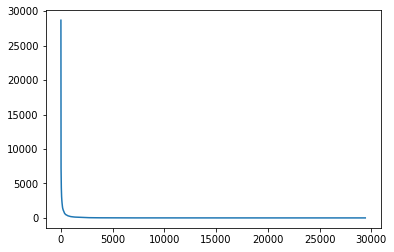

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

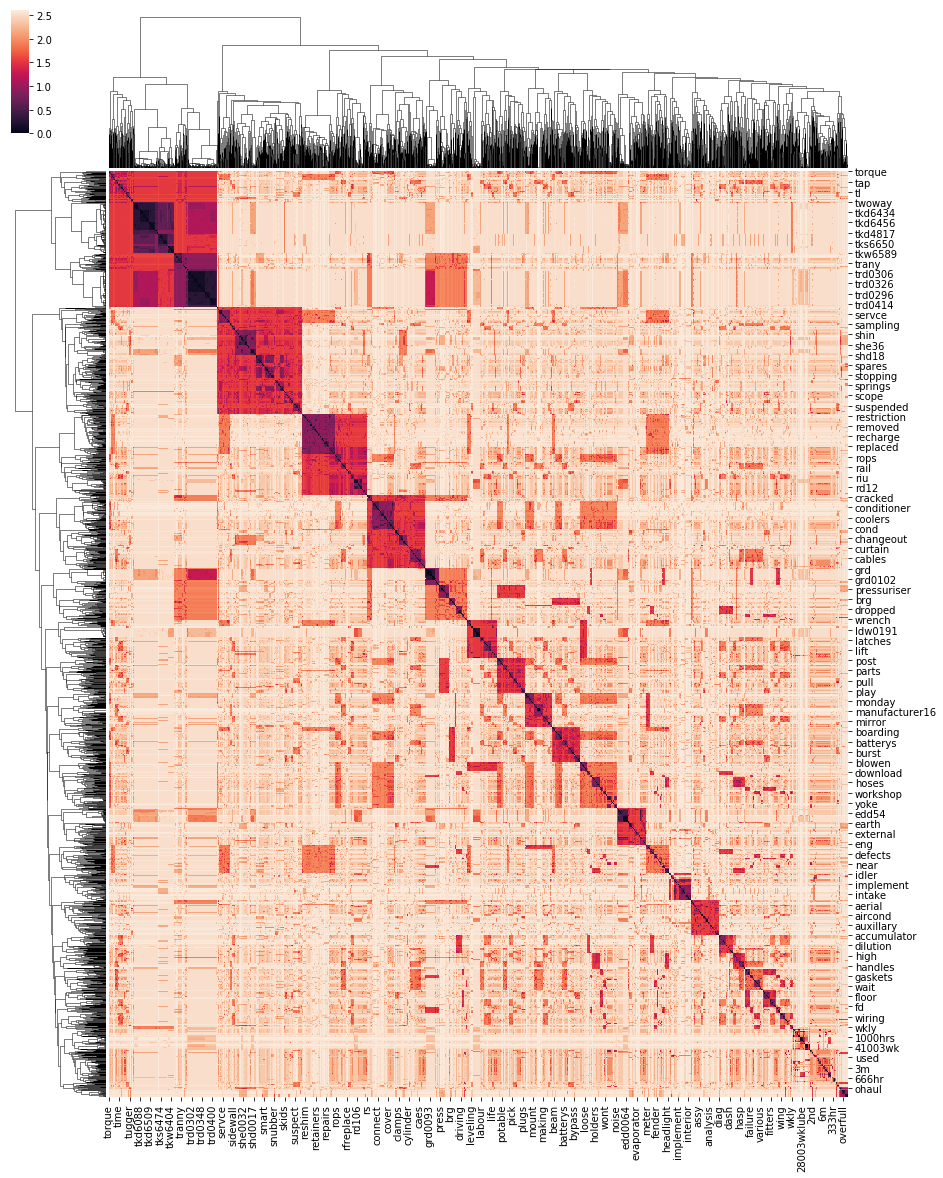

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()